In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-04-16 14:43:48.379438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 14:43:50.419759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744814631.116999   10127 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744814631.318267   10127 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744814633.374524   10127 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Define dataset path
train_dir = "Dataset/train"
valid_dir = "Dataset/valid"

# Define image size
img_size = (224, 224)
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Get class labels
class_labels = list(train_generator.class_indices.keys())
print(f"Class Labels: {class_labels}")

Found 3665 images belonging to 5 classes.
Found 916 images belonging to 5 classes.
Class Labels: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [4]:
def build_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_labels), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
def build_resnet():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze pre-trained layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
def build_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:

def build_efficientnet():
    # Load EfficientNetB0 as the base model, excluding the top classification layers
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model layers

    # Build the custom model on top of EfficientNetB0
    model = Sequential([
        base_model,
        Flatten(),  # Flatten the output of the base model
        Dense(128, activation='relu'),  # Fully connected layer
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(len(class_labels), activation='softmax')  # Final output layer for classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

# 1. Check for available GPU and print
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU(s) available: {[gpu.name for gpu in gpus]}")
    try:
        # Optional: Set memory growth to avoid allocation issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("🛠️ GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"❌ Error setting GPU memory growth: {e}")
else:
    print("❌ No GPU available. Training will use CPU.")

# 2. Now define your models (assumed you have functions like build_cnn, etc.)
models = {
    "CNN": build_cnn(),
    "ResNet50": build_resnet(),
    "VGG16": build_vgg16(),
    "EfficientNetB0": build_efficientnet()
}

# 3. Training and evaluation loop
history_dict = {}
evaluation_results = {}

for model_name, model in models.items():
    print(f"\n🚀 Training {model_name}...")

    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        history = model.fit(
            train_generator,
            validation_data=valid_generator,
            epochs=10
        )

        # Save model
        model.save(f"{model_name}_diabetic_retinopathy.h5")

        # Store training history
        history_dict[model_name] = history

        # Evaluate model
        loss, accuracy = model.evaluate(valid_generator)
        evaluation_results[model_name] = {"Loss": loss, "Accuracy": accuracy}

print("✅ Training and Evaluation Complete!")


✅ GPU(s) available: ['/physical_device:GPU:0']
🛠️ GPU memory growth enabled.


/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744814663.465840   10127 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



🚀 Training CNN...


/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1744814669.334221   10489 service.cc:152] XLA service 0x7fcd30005130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744814669.334257   10489 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-16 14:44:29.531599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744814669.883964   10489 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/115 ━━━━━━━━━━━━━━━━━━━━ 15:33 8s/step - accuracy: 0.2188 - loss: 1.6292

I0000 00:00:1744814676.209652   10489 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.1928 - loss: 1.6531

2025-04-16 14:45:07.522294: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 4 bytes spill stores, 4 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.1929 - loss: 1.6528 - val_accuracy: 0.2544 - val_loss: 1.5920
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - accuracy: 0.2161 - loss: 1.6064 - val_accuracy: 0.2707 - val_loss: 1.5886
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - accuracy: 0.2334 - loss: 1.6053 - val_accuracy: 0.2598 - val_loss: 1.5913
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.2396 - loss: 1.5955 - val_accuracy: 0.2467 - val_loss: 1.5910
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.2433 - loss: 1.5970 - val_accuracy: 0.2795 - val_loss: 1.5851
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.2329 - loss: 1.5952 - val_accuracy: 0.2544 - val_loss: 1.5859
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.2196 - loss: 1.5967 - val_accuracy: 0.2598 - val_loss: 1.5820
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - accuracy: 0.2433 - loss: 1.5889 - val

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.2936 - loss: 1.5667

🚀 Training ResNet50...
Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - accuracy: 0.2006 - loss: 1.7948 - val_accuracy: 0.2151 - val_loss: 1.6091
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.2294 - loss: 1.6091 - val_accuracy: 0.2151 - val_loss: 1.6087
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.2264 - loss: 1.6108 - val_accuracy: 0.2336 - val_loss: 1.6081
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 242ms/step - accuracy: 0.2006 - loss: 1.6085 - val_accuracy: 0.2336 - val_loss: 1.6075
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - accuracy: 0.2180 - loss: 1.6081 - val_accuracy: 0.2162 - val_loss: 1.6070
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.2270 - loss: 1.6080 - val_accuracy: 0.2162 - val_loss: 1.6065
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 243ms/step - accuracy: 0.2123 - loss: 1.6080 - val_accuracy: 0.2162 - va

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.2280 - loss: 1.6047

🚀 Training VGG16...
Epoch 1/10


2025-04-16 14:54:17.805094: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-16 14:54:18.067249: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-16 14:54:21.244773: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may i

115/115 ━━━━━━━━━━━━━━━━━━━━ 49s 335ms/step - accuracy: 0.2194 - loss: 1.7347 - val_accuracy: 0.2434 - val_loss: 1.5843
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.2168 - loss: 1.5985 - val_accuracy: 0.2325 - val_loss: 1.5885
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 314ms/step - accuracy: 0.2194 - loss: 1.5941 - val_accuracy: 0.2522 - val_loss: 1.5688
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 251ms/step - accuracy: 0.2464 - loss: 1.5906 - val_accuracy: 0.2336 - val_loss: 1.5880
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 350ms/step - accuracy: 0.2202 - loss: 1.5905 - val_accuracy: 0.2500 - val_loss: 1.5888
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 343ms/step - accuracy: 0.2368 - loss: 1.5866 - val_accuracy: 0.2609 - val_loss: 1.5707
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step - accuracy: 0.2263 - loss: 1.5866 - val_accuracy: 0.2653 - val_loss: 1.5572
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - accuracy: 0.2398 - loss: 1.5783 - val

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.2887 - loss: 1.5506

🚀 Training EfficientNetB0...
Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 410ms/step - accuracy: 0.2143 - loss: 1.7499 - val_accuracy: 0.2162 - val_loss: 1.6089
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 244ms/step - accuracy: 0.2219 - loss: 1.6095 - val_accuracy: 0.2162 - val_loss: 1.6084
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.2407 - loss: 1.6086 - val_accuracy: 0.2162 - val_loss: 1.6079
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.2093 - loss: 1.6086 - val_accuracy: 0.2162 - val_loss: 1.6074
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 238ms/step - accuracy: 0.2117 - loss: 1.6080 - val_accuracy: 0.2162 - val_loss: 1.6069
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.2174 - loss: 1.6078 - val_accuracy: 0.2162 - val_loss: 1.6064
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.2122 - loss: 1.6081 - val_accuracy: 0.216

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.2202 - loss: 1.6055
✅ Training and Evaluation Complete!


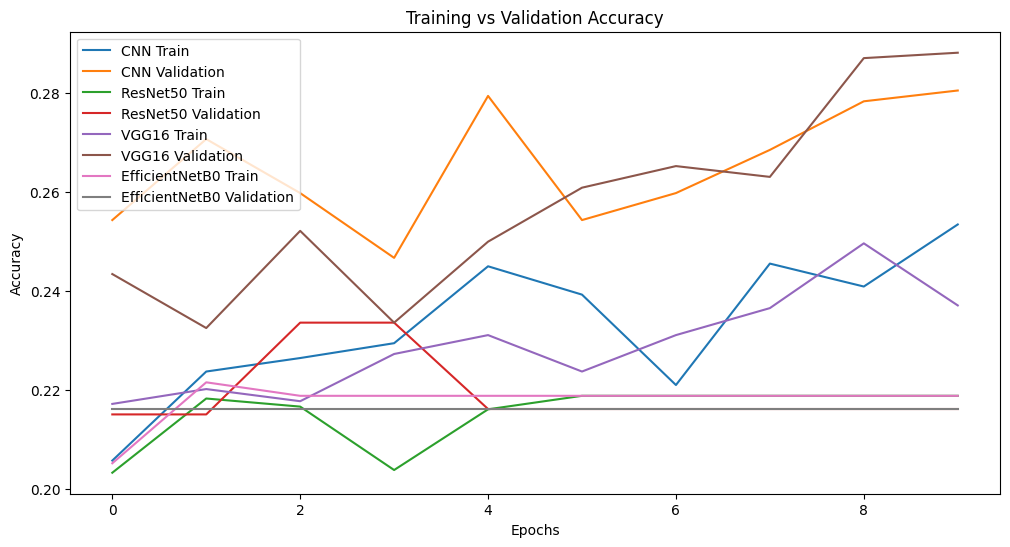

In [9]:
plt.figure(figsize=(12, 6))

for model_name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f"{model_name} Train")
    plt.plot(history.history['val_accuracy'], label=f"{model_name} Validation")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Classification Report for CNN:
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


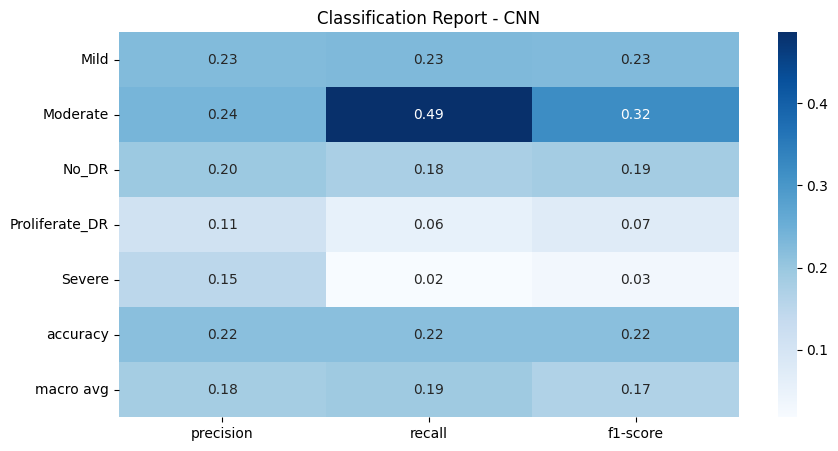


Classification Report for ResNet50:
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step


/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

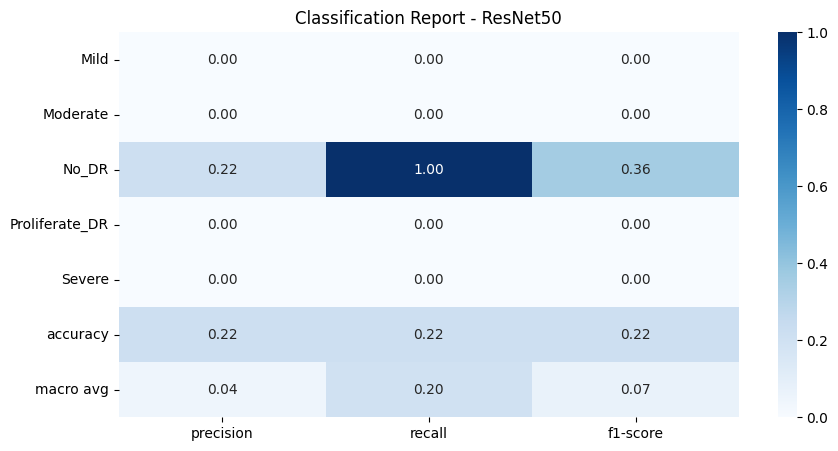


Classification Report for VGG16:
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


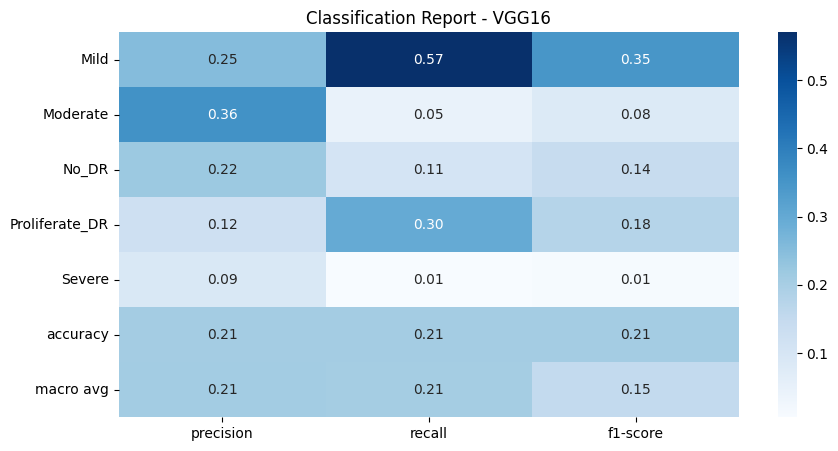


Classification Report for EfficientNetB0:
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step


/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/ASUS/Desktop/Arya/Medical-Image-Captioning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

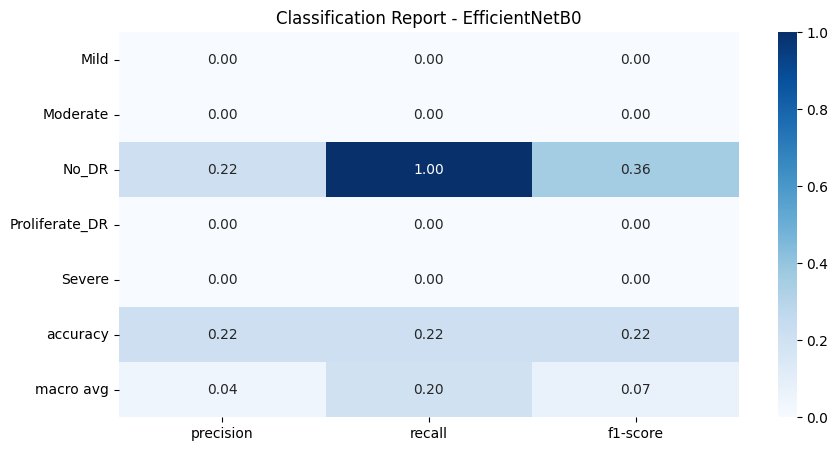

In [10]:
def evaluate_model(model, generator, model_name):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    
    # Convert to DataFrame and plot
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 5))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"Classification Report - {model_name}")
    plt.show()
    
    return report

# Evaluate and compare models
for model_name, model in models.items():
    print(f"\nClassification Report for {model_name}:")
    report = evaluate_model(model, valid_generator, model_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


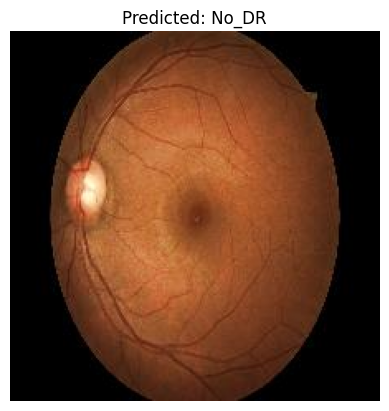

'No_DR'

In [19]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define your class labels
class_labels = list(train_generator.class_indices.keys())

def test_model(model_path, image_path):
    model = tf.keras.models.load_model(model_path)

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image from path: {image_path}")
        return None

    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Show Image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

    return predicted_label

# Test Image
image_path = "Dataset/valid/No_DR/13_left_png.rf.66c029d08da0b9a82c6c1e8853948b13.jpg"
test_model("ResNet50_diabetic_retinopathy.h5", image_path)
